# Labeling of Measurements and Label Propagation

MVG comes with a labeling API that allows a user to store important information about a measurement.
There are multiple reasons why you would want to label measurements and some of the benefits include:

1.  Additional information about modes. For example, a mode with multiple critical measurements is likely a failure mode.
2.  Improved mode detection.
3.  As personal notes for keeping track of interesting events in the data.

In addition, the LabelPropagation feature enables to propagate those labels to the measurements that do not contain any labels.

This example will go through what a label is in MVG, how the labeling API functions, and how to utilize the LabelPropagation feature.

### Prerequisites

To follow this example you need to have:

1. Installed `mvg` package
2. A token for API access from Viking Analytics
3. The database needs to be populated with our example assets. This can be achieved by running the ["Sources and Measurement"](2-sources_and_measurements.ipynb) example.
4. Use of the LabelPropagation feature requires the results from ModeId. We can use the results available after running the ["Analysis and Results Visualization"](6-analysis_visual.ipynb) example.

### Import the required packages and functions

In [1]:
import os
from mvg import MVG
from mvg.analysis_classes import parse_results
from mvg.plotting import plot_labels_over_time

### Create a session for API access

.. note:: Each token is used for Authorization AND Authentication. Thus, each unique token represents a unique user, each user has it own, unique database on the VA-MVG' service.

**You need to insert your token received from Viking Analytics here:**

In [2]:
TOKEN = os.environ["TEST_TOKEN"]
ENDPOINT = "https://api.beta.multiviz.com"

In [3]:
session = MVG(ENDPOINT, TOKEN)
session.check_version()

{'api_version': '0.3.2',
 'mvg_highest_tested_version': '0.3.2',
 'mvg_version': '0.12.2'}

## Retrieve ModeId results

Once the API session is live, we start by checking if the source `u0001` we will use is available in the database.

In [4]:
SOURCE_ID = "u0001"
session.get_source(SOURCE_ID)

{'source_id': 'u0001',
 'meta': {'assetId': 'assetA',
  'measPoint': 'mloc01',
  'location': 'paris',
  'updated': 'YES! I have been updated'},
 'properties': {'data_class': 'waveform', 'channels': ['acc']}}

Now that we know that the source exists we need to check its measurements to know which ones to label.

In this example, the ModeId results are used to select the measurements to label and to compare with the results from the LabelPropagation feature.
The ModeId results are NOT needed to add a label to the measurements.

In [6]:
ModeId_request_id = session.list_analyses(sid=SOURCE_ID, feature="ModeId")[-1]
raw_result = session.get_analysis_results(ModeId_request_id)
result = parse_results(raw_result, "Europe/Stockholm", "s")
u0001_df = result.to_df()
u0001_df.head()

,timestamps,labels,uncertain,mode_probability,datetime
0,1570186860,0,False,0.912743,2019-10-04 13:01:00+02:00
1,1570273260,0,False,0.972841,2019-10-05 13:01:00+02:00
2,1570359660,0,False,0.929741,2019-10-06 13:01:00+02:00
3,1570446060,0,False,0.999620,2019-10-07 13:01:00+02:00
4,1570532460,0,False,0.978940,2019-10-08 13:01:00+02:00


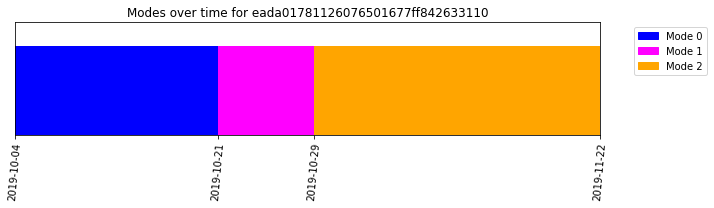

''

In [7]:
result.plot()


## Adding labels

A label in MVG relates to a specific measurement, which are identifiable by the source ID and the timestamp.
Each measurement can only have one label.
The label itself has three components:

1. A label identification string
2. A severity level number
3. Notes

.. note:: The label identification string is unique for each label and is case and spelling sensitive, i.e. `"failure"` and `"Failure"` are not interpreted as the same label. The severity level is an integer where a larger number indicates a more severe problem. They do not need to be the same for different instances of the same label. The notes exist for the end user to add extra information to a certain label and is not used by MVG in any way.

For this example, let us say that there was a bearing failure of the machine in the first measurement of the source, so we will add a label to the afflicted measurements. To do so, we use the `MVG.create_label()` method.

In [8]:
first_measurement = 1570273260
session.create_label(
    sid=SOURCE_ID,
    timestamp=1570273260,
    label="bearing_failure",
    severity=3,
    notes="Imaginary bearing failure"
)

We just added one label to one of the measurements of the source.
However, just one label for the entire source might not be enough especially if the modeId results show more than one mode.
Therefore, it might be a good idea to add more labels.
Thus, we proceed to attach a label to the top 3 measurements with the largest mode probability of mode from the ModeId feature results.
First, we create a dataframe to identify these measurements.

In [9]:
Top3meas_df = u0001_df[u0001_df.groupby('labels')['mode_probability'].rank(method='dense', ascending=False) <= 3]
Top3meas_df

,timestamps,labels,uncertain,mode_probability,datetime
3,1570446060,0,False,0.999620,2019-10-07 13:01:00+02:00
8,1570878060,0,False,0.996754,2019-10-12 13:01:00+02:00
9,1570964460,0,False,0.994076,2019-10-13 13:01:00+02:00
18,1571742060,1,False,0.997126,2019-10-22 13:01:00+02:00
20,1571914860,1,False,0.995323,2019-10-24 13:01:00+02:00
23,1572177660,1,False,0.996432,2019-10-27 13:01:00+01:00
33,1573041660,2,False,0.999948,2019-11-06 13:01:00+01:00
37,1573387260,2,False,0.999831,2019-11-10 13:01:00+01:00
40,1573646460,2,False,0.999388,2019-11-13 13:01:00+01:00


There are three modes on the ModeId results.
We will label measurements from mode 0 as "Healthy", measurements from mode 1 as "Transition", measurements from mode 2 as "Faulty".

In [10]:
modes = Top3meas_df['labels'].unique()
mode_dfs = {mode: Top3meas_df[Top3meas_df['labels'] == mode] for mode in modes}

for mode in mode_dfs:
    if mode == 0:
        label_to_add = "Healthy"
    elif mode == 1:
        label_to_add = "Transition"
    else:
        label_to_add = "Faulty"
    case_df = mode_dfs[mode]

    for index, row in case_df.iterrows():
        session.create_label(
            sid=SOURCE_ID,
            timestamp=row['timestamps'],
            label=label_to_add,
            severity=int(mode)+1,
            notes="This is a demo."
        )


### Reading Labels

To get a list of all the labels for a source we use the `MVG.list_labels()` method.

In [11]:
session.list_labels(SOURCE_ID)

[{'timestamp': 1570273260,
  'label': 'bearing_failure',
  'severity': 3,
  'notes': 'Imaginary bearing failure',
  'label_timestamp': '2022-03-02 19:39:40'},
 {'timestamp': 1570446060,
  'label': 'Healthy',
  'severity': 1,
  'notes': 'This is a demo.',
  'label_timestamp': '2022-03-02 19:40:23'},
 {'timestamp': 1570878060,
  'label': 'Healthy',
  'severity': 1,
  'notes': 'This is a demo.',
  'label_timestamp': '2022-03-02 19:40:23'},
 {'timestamp': 1570964460,
  'label': 'Healthy',
  'severity': 1,
  'notes': 'This is a demo.',
  'label_timestamp': '2022-03-02 19:40:24'},
 {'timestamp': 1571742060,
  'label': 'Transition',
  'severity': 2,
  'notes': 'This is a demo.',
  'label_timestamp': '2022-03-02 19:40:24'},
 {'timestamp': 1571914860,
  'label': 'Transition',
  'severity': 2,
  'notes': 'This is a demo.',
  'label_timestamp': '2022-03-02 19:40:24'},
 {'timestamp': 1572177660,
  'label': 'Transition',
  'severity': 2,
  'notes': 'This is a demo.',
  'label_timestamp': '2022-03-0

As you can see, the measurements that we just added labels show up.
To inspect the label of a specific measurement we use `MVG.get_label()`

In [12]:
session.get_label(SOURCE_ID, first_measurement)

{'label': 'bearing_failure',
 'severity': 3,
 'notes': 'Imaginary bearing failure',
 'label_timestamp': '2022-03-02 19:39:40'}

### Updating labels

Now we realize that the label we had in the first measurement correspond to mode 0 and the label that we originally added is incorrect.
Then we use the `session.update_label()` method to change the label.

In [13]:
session.update_label(
    sid=SOURCE_ID,
    timestamp=first_measurement,
    label="healthy",
    severity=0,
    notes="This was an OK measurement"
)

# List the labels again
labels = session.list_labels(SOURCE_ID)
labels

[{'timestamp': 1570273260,
  'label': 'healthy',
  'severity': 0,
  'notes': 'This was an OK measurement',
  'label_timestamp': '2022-03-02 19:39:40'},
 {'timestamp': 1570446060,
  'label': 'Healthy',
  'severity': 1,
  'notes': 'This is a demo.',
  'label_timestamp': '2022-03-02 19:40:23'},
 {'timestamp': 1570878060,
  'label': 'Healthy',
  'severity': 1,
  'notes': 'This is a demo.',
  'label_timestamp': '2022-03-02 19:40:23'},
 {'timestamp': 1570964460,
  'label': 'Healthy',
  'severity': 1,
  'notes': 'This is a demo.',
  'label_timestamp': '2022-03-02 19:40:24'},
 {'timestamp': 1571742060,
  'label': 'Transition',
  'severity': 2,
  'notes': 'This is a demo.',
  'label_timestamp': '2022-03-02 19:40:24'},
 {'timestamp': 1571914860,
  'label': 'Transition',
  'severity': 2,
  'notes': 'This is a demo.',
  'label_timestamp': '2022-03-02 19:40:24'},
 {'timestamp': 1572177660,
  'label': 'Transition',
  'severity': 2,
  'notes': 'This is a demo.',
  'label_timestamp': '2022-03-02 19:40

### Plotting labels

To get an overview of the data and labels it can be very good to plot the labels over time.
The `plotting` module of `mvg` contains the function `plot_labels_over_time` that does just that.
The plot is very similar to that of the ModeId plots, so it is easy to compare results.
We can add the `include_unlabeled=True` keyword to plot the unlabeled measurements as well.
Please note how "healthy" and "Healthy" was interpreted as two different labels.

[]

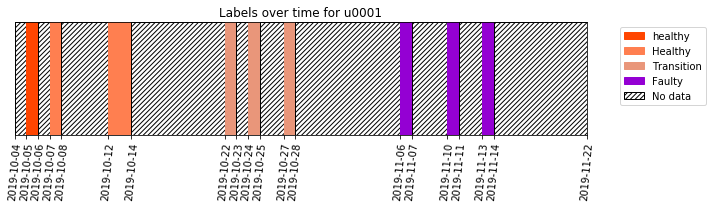

In [14]:
labels = session.list_labels(SOURCE_ID, include_unlabeled=True)
plot_labels_over_time(labels, SOURCE_ID, timeunit="s")

As you can see we only labeled a small subset of the data.
The idea is not to label all the measurements, but to label a part and then use that information to make inference about the unlabeled measurements.

### Deleting labels

Now, we check the total number of existing labels in our source.

In [15]:
labels = session.list_labels(SOURCE_ID)
print(f"Currently, there are {len(labels)} labels")

Currently, there are 10 labels


To delete labels we use the `MVG.delete_label()` method.
Let's use that to remove the label from the first measurement and keep only three labels per mode.

In [16]:
session.delete_label(SOURCE_ID, first_measurement)

In [17]:
labels = session.list_labels(SOURCE_ID)
print(f"Currently, there are {len(labels)} labels")

Currently, there are 9 labels


## Label Propagation

Until this point, we had added labels to some of our measurements but we might be interested on adding the labels to the rest of the measurements.
We use the [`LabelPropagation`](../features/label_propagation.md) feature to achieve this.

The `LabelPropagation` feature uses the results from the ModeId feature to propagate the labels.
However, the labels are attached to each measurement individually and not to the modes as a whole.

To use the `LabelPropagation` feature, we need to know which source is to be used and the `request_id` that holds the results of the ModeId feature.
Then, we can request the analysis.


In [18]:
params = {"model_ref": ModeId_request_id}
labelProp_u0001 = session.request_analysis(SOURCE_ID, "LabelPropagation", params)
labelProp_request_id = labelProp_u0001["request_id"]
labelProp_u0001

{'request_id': '5a3c573907ce61089b3c2899496f3214', 'request_status': 'queued'}

We check the status of the analysis to ensure the analysis is finished.

In [19]:
session.wait_for_analyses([labelProp_request_id])
out_status =  session.get_analysis_status(labelProp_request_id)
out_status

'successful'

Before we are able to get the analysis results, we need to wait until those analyses are successfully completed.
Once the analysis is complete, one gets the results by calling the corresponding “request_id” for the LabelPropagation analysis.
The raw results can be retrieved by calling the `get_analysis_results` function.

In [20]:
labelprop_output = session.get_analysis_results(request_id=labelProp_request_id)
labelprop_output.keys()

dict_keys(['status', 'request_id', 'feature', 'results', 'inputs', 'error_info', 'debug_info'])

The output is a dictionary that contains seven key elements.
These elements are:

* `"status"` indicates if the analysis was successful.

* `"request_id"` is the identifier of the requested analysis.

* `"feature"` is the name of the request feature.

* `"results"` includes the numeric results.

* `"inputs"` includes the input information for the request analysis.

* `"error_info"` includes the error information in case the analysis fails and it is empty if the analysis is successful.

* `"debug_info"` includes debugging (log) information related to the failed analysis.

To make the results more accessible, we’ll use the analysis_classes.
The `parse_results` function will take the raw_results of (any) analysis and represent them in a python object with a number of convenience methods for plotting and exporting.
The parse function will automatically determine the kind (feature) of analysis based on the raw_results and based on the defined timezone convert the epoch into actual dates.

In [21]:
labelprop_results = parse_results(labelprop_output, "Europe/Stockholm", "s")


Once we had parsed the results, we can export them to a dataframe for ease of manipulation

In [22]:
labelprop_results.to_df()


,label,severity,notes,label_timestamp,timestamp,datetime
0,Healthy,-1,Added by label propagation,2022-03-02 19:43:50,1570186860,2019-10-04 13:01:00+02:00
1,Healthy,-1,Added by label propagation,2022-03-02 19:43:50,1570273260,2019-10-05 13:01:00+02:00
2,Healthy,-1,Added by label propagation,2022-03-02 19:43:50,1570359660,2019-10-06 13:01:00+02:00
3,Healthy,1,This is a demo.,2022-03-02 19:40:23,1570446060,2019-10-07 13:01:00+02:00
4,Healthy,-1,Added by label propagation,2022-03-02 19:43:50,1570532460,2019-10-08 13:01:00+02:00
5,Healthy,-1,Added by label propagation,2022-03-02 19:43:50,1570618860,2019-10-09 13:01:00+02:00
6,Healthy,-1,Added by label propagation,2022-03-02 19:43:50,1570705260,2019-10-10 13:01:00+02:00
7,Healthy,-1,Added by label propagation,2022-03-02 19:43:50,1570791660,2019-10-11 13:01:00+02:00
8,Healthy,1,This is a demo.,2022-03-02 19:40:23,1570878060,2019-10-12 13:01:00+02:00
9,Healthy,1,This is a demo.,2022-03-02 19:40:24,1570964460,2019-10-13 13:01:00+02:00


We can also display the results and visualize the labels given to the different measurements.

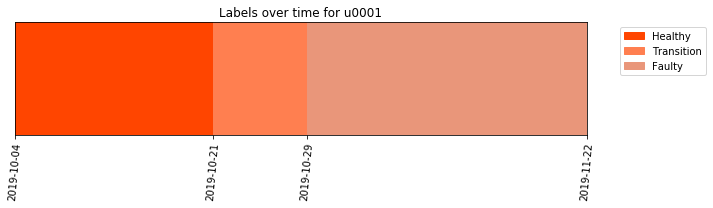

''

In [23]:
labelprop_results.plot()

As you can see from the results, it is easier to appreciate now which measurements have a healthy behavior, which measurements have a faulty behavior and which measurements have a transition behavior from healthy to faulty.
